In [1]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime

import scipy
import scipy.ndimage
import scipy.spatial
from scipy.spatial import KDTree


Importing webbpsf


In [2]:
import importlib as imp
imp.reload(crowdsource)
from crowdsource import crowdsource_base
imp.reload(crowdsource.crowdsource_base)
from crowdsource.crowdsource_base import fit_im, psfmod
from webbpsf.utils import to_griddedpsfmodel

In [3]:
filt = filtername = 'f410m'
#filt = filtername = 'f444w'

In [4]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [5]:
im1 = fits.open(f'{basepath}/F410M/pipeline/jw02221001001_07101_00024_nrcblong_destreak_o001_crf.fits')
#im1 = fits.open(f'{basepath}/F444W/pipeline/jw01182004002_04101_00010_nrcalong_destreak_o004_crf.fits')
obsdate = im1[0].header['DATE-OBS']
ww = wcs.WCS(im1[1].header)

module = 'nrcb'
data = im1['SCI'].data[:400,:400]
err = im1['ERR'].data[:400,:400]
if 'WHT' in im1:
    wht = im1['WHT'].data[:400,:400]
else:
    wht = 1
dq = im1['DQ'].data[:400, :400]

In [6]:
im1.info()

Filename: /blue/adamginsburg/adamginsburg/jwst/brick//F410M/pipeline/jw02221001001_07101_00024_nrcblong_destreak_o001_crf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     363   ()      
  1  SCI           1 ImageHDU       133   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   uint32   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [48363B]   


In [7]:
has_downloaded = False
ntries = 0
while not has_downloaded:
    try:
        nrc = webbpsf.NIRCam()
        nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
        nrc.filter = filt
        if module in ('nrca', 'nrcb'):
            if 'F4' in filt.upper():
                nrc.detector = f'{module.upper()}5' # I think NRCA5 must be the "long" detector?
            else:
                nrc.detector = f'{module.upper()}1' #TODO: figure out a way to use all 4?
            grid = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True, save=True)
        else:
            grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
        has_downloaded = True
    except (urllib3.exceptions.ReadTimeoutError, requests.exceptions.ReadTimeout, requests.HTTPError) as ex:
        print(f"Failed to build PSF: {ex}", flush=True)
    except Exception as ex:
        print(ex, flush=True)
        if ntries > 10:
            # avoid infinite loops
            raise ValueError("Failed to download PSF, probably because of an error listed above")
        else:
            continue


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCB5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.50624611033805, 201.04491630614913)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.53563193116167, 201.0039664

In [8]:
import sys
sys.path.append(f'{basepath}/analysis')
import crowdsource_catalogs_long
from crowdsource_catalogs_long import WrappedPSFModel

Starting crowdsource_catalogs_long
Importing webbpsf
2024-07-11T16:16:14.272061: Done with imports


In [9]:
psf_model = WrappedPSFModel(grid)

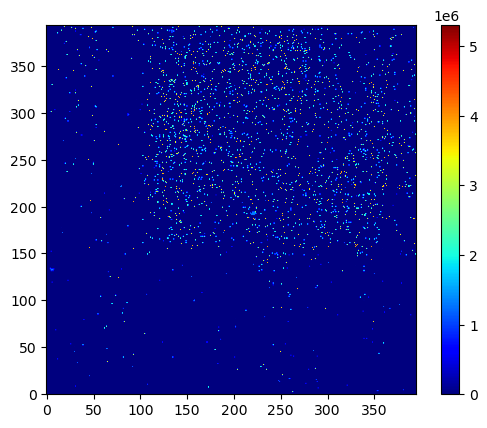

In [10]:
pl.imshow(im1['DQ'].data[5:400,5:400], cmap='jet');
pl.colorbar();

# Start tests

In [11]:
# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
#maxweight = np.percentile(weight[np.isfinite(weight)], 95)
#minweight = np.percentile(weight[np.isfinite(weight)], 5)
#badweight =  np.percentile(weight[np.isfinite(weight)], 1)
#weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (data < 1e-5) | (dq != 0)


#weight[weight > maxweight] = maxweight
#weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
#weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

# Expand bad pixel zones for dq
#bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
#print(f"Total bad pixels = {bad.sum()}, total bad for dq={bad_for_dq.sum()}")
#
#dq = np.zeros(data.shape, dtype='int')
#bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
#dq[bad_for_dq] = 2 | 2**30 | 2**31

mask = bad

#mask = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(mask, iterations=1), iterations=1)
#mask = scipy.ndimage.binary_erosion(scipy.ndimage.binary_dilation(mask, iterations=1), iterations=1)

In [12]:
data.shape, data.size, mask.sum(), bad.sum()

((400, 400), 160000, 7515, 7515)

In [13]:
from scipy.spatial import KDTree

# crowdsource

In [14]:
results  = fit_im(np.nan_to_num(data), psf_model, weight=weight,
                  dq=dq,
                  nskyx=0, nskyy=0, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results
residual = data - modsky
model = modsky
result = stars = Table(stars)
stars['x'], stars['y'] = stars['y'], stars['x']

Too many bright sources, using smaller PSF stamp size...
Starting subregion iterations
Subregion iteration 0 finished; dt=20.450833082199097
threshold=5, median fluxunc=0.040026403963565826, median flux=70.61274719238281 time=20.509644031524658
Extension None, iteration  1, found   2334 sources;    4 close and  433 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=24.348013639450073
threshold=5, median fluxunc=0.03566478192806244, median flux=77.58840942382812 time=24.43219828605652
Extension None, iteration  2, found    706 sources;   17 close and  296 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=40.75220775604248
threshold=5, median fluxunc=0.04351580888032913, median flux=60.766075134277344 time=40.87323617935181
Extension None, iteration  3, found   2348 sources;  141 close and  214 faint sources removed.
Starting subregion iterations
Subregion iteration 0 finished; dt=52.213828563690186
threshold=5, m

In [15]:
len(stars)

7651

In [16]:
Table(stars[:3])

<Table length=3>
        x                  y             flux    passno      dx          dy       dflux       qf       rchi2   ...  dfluxlbs    fwhm   spread_model dspread_model fluxiso          xiso                 yiso            flags       sky   
     float64            float64        float32  float64   float32     float32    float32   float32    float32  ...  float32   float32    float32       float32    float32        float64              float64           int32     float32 
------------------ ------------------ --------- ------- ----------- ----------- --------- ---------- --------- ... --------- --------- ------------ ------------- -------- -------------------- -------------------- ----------- ---------
 89.72647813335061             -0.499  4433.841     0.0 0.034310475  0.05788569 116.17907 0.03633316 30.352545 ... 145.99483 2.8553123  0.012613952  0.0021483684 4344.234 -0.14600139811313737 0.003935845680157483 -2143813631 10.366993
 43.33417813626958 3.4065230434934373   131.162     0.0  0.05421013 0.078846686 6.2860384 0.32998696 26.309374 ...  6.892379 2.8548553  0.011192739  0.0027995221 96.05842    0.503951211418642   1.5227488130202853 -2143813631 10.678587
183.78136629980628  4.342457787727942 53.537384     0.0   0.1255867  0.10079318 3.1416621 0.66809607  8.041593 ... 3.2344549 2.8562243 0.0076547265  0.0023893602 51.23538   0.1886102401398789  0.11867207746350675           0 10.420689

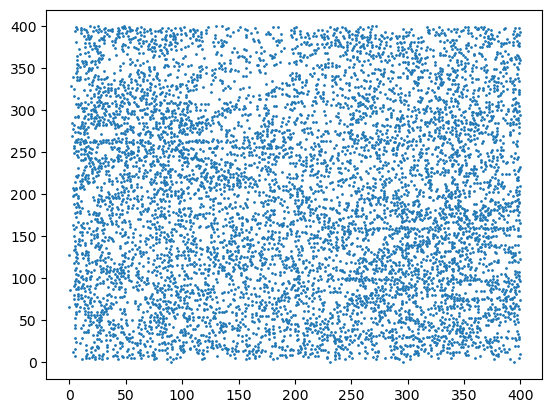

In [17]:
pl.scatter(result['x'], result['y'], s=1)

In [18]:
dist, ind = KDTree(np.array([result['x'], result['y']]).T).query(np.array([result['x'], result['y']]).T, 2) 
close_neighbor = ind[:,1][dist[:,1] < 1]

len(close_neighbor), len(stars)

(0, 7651)

### Default

### Histograms

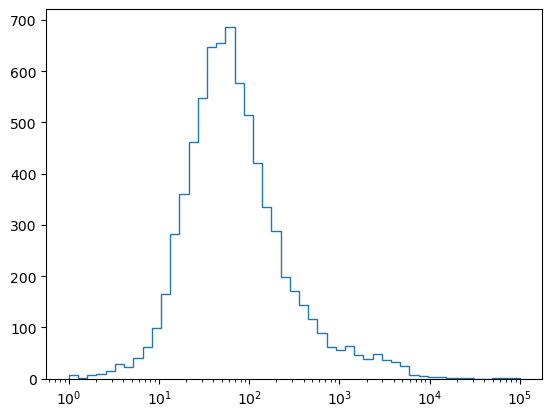

In [19]:
pl.hist(result['flux'], bins=np.logspace(0,5), histtype='step')
#pl.hist(result_g['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.xscale('log');

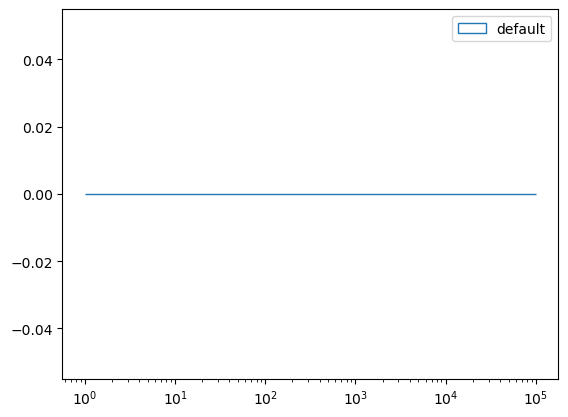

In [20]:
pl.hist(result['flux'][close_neighbor], bins=np.logspace(0,5), histtype='step', label='default')
pl.xscale('log');
pl.legend(loc='best');

In [35]:
np.unique(dq)

array([         0,          3,         17,       2049,      16385,
            32769,      65536,      81921,    1114113,    1116161,
          1117187,    1311745,    1312769,    1327105,    1328129,
          4194304,    4194307,    4194321,    4196353,    4210689,
          4227073,    4259840,    5310465, 2151153665, 2155347969],
      dtype=uint32)

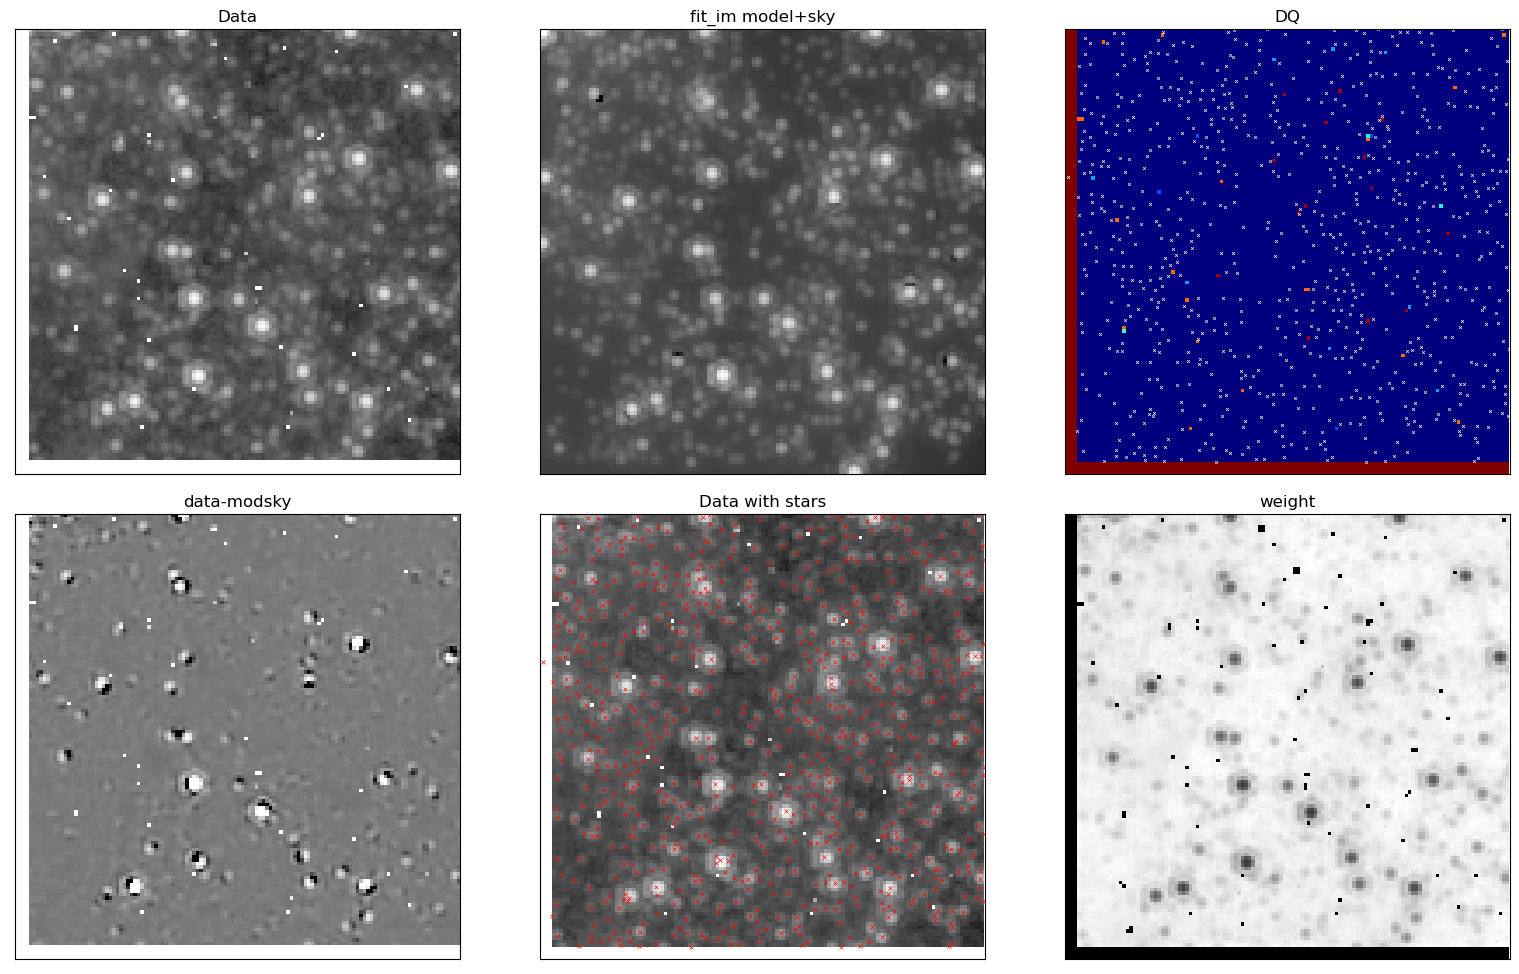

In [36]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh',
                                                                    max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x'], stars['y'], marker='x', color='r', s=8, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,128,0,128])
pl.subplot(2,3,3).imshow((dq)[:128,:128], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x'], stars['y'], marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,:128], norm=simple_norm(weight[:128,:128], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

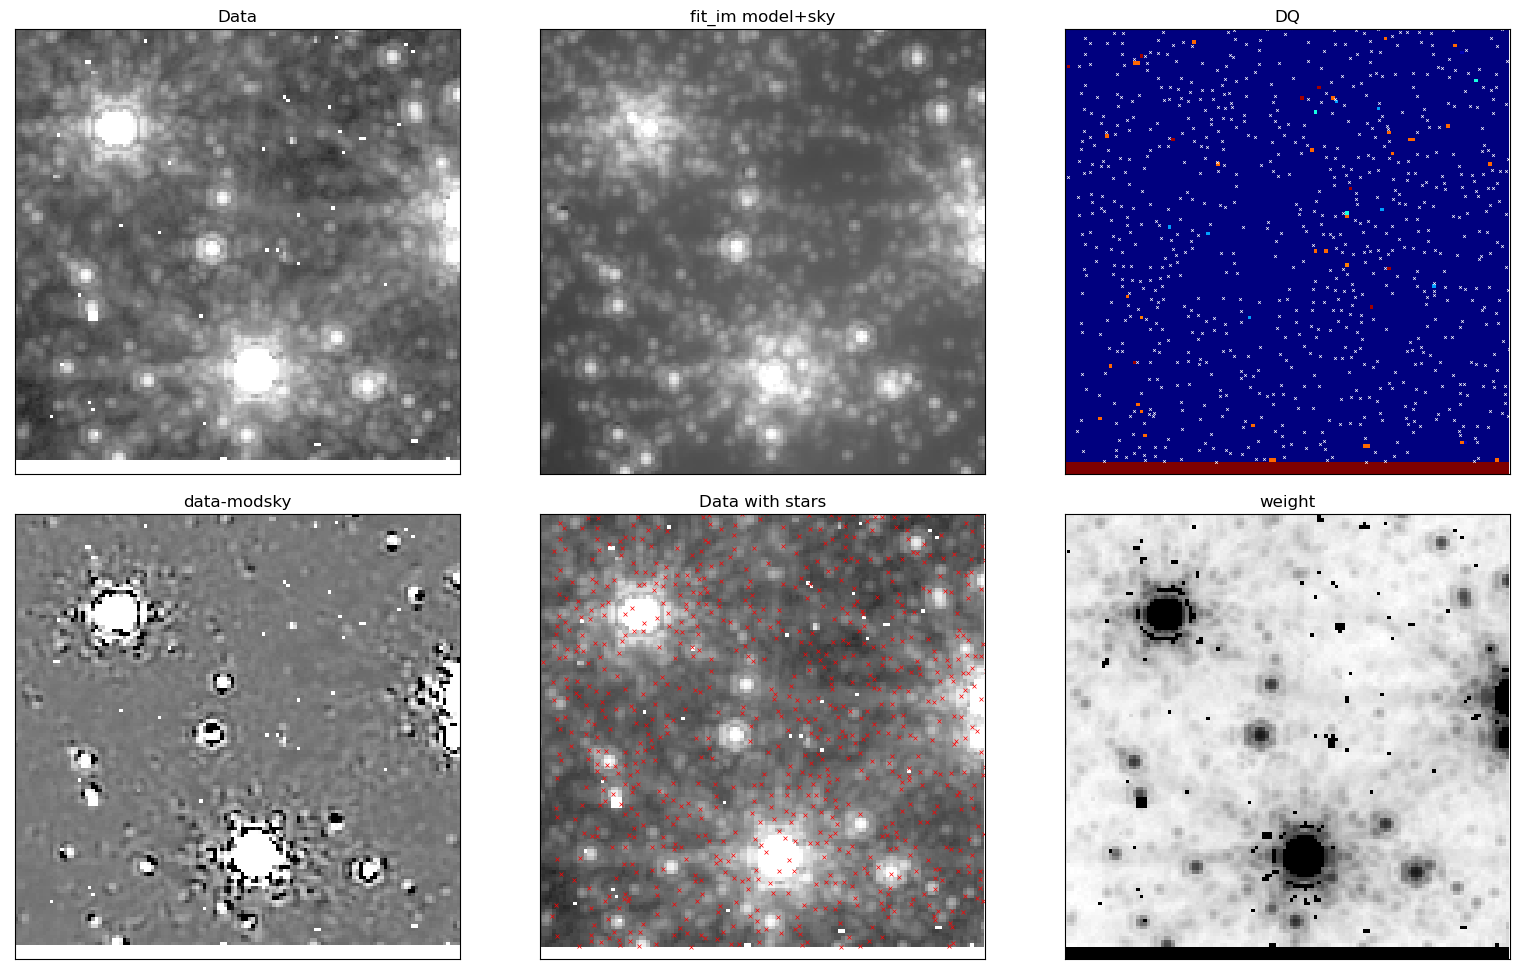

In [38]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,-128:], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(modsky[:128,-128:], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-modsky)[:128,-128:], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,3,5).imshow(data[:128,-128:], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(stars['x'], stars['y'], marker='x', color='r', s=8, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.axis([0,128,0,128])
pl.subplot(2,3,3).imshow((dq)[:128,-128:], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
pl.subplot(2,3,3).scatter(stars['x'], stars['y'], marker='x', color='w', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,-128:], norm=simple_norm(weight[:128,-128:], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(stars['x'], stars['y'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

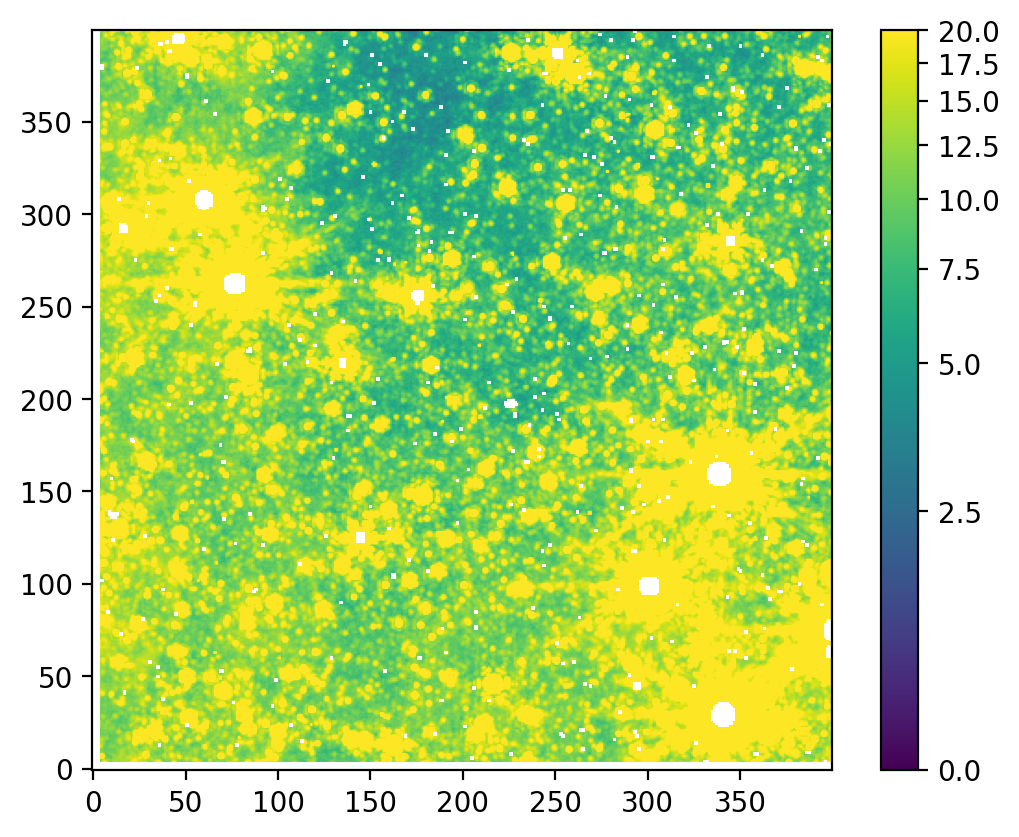

In [22]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=0, max_cut=20, stretch='asinh'))
pl.colorbar();

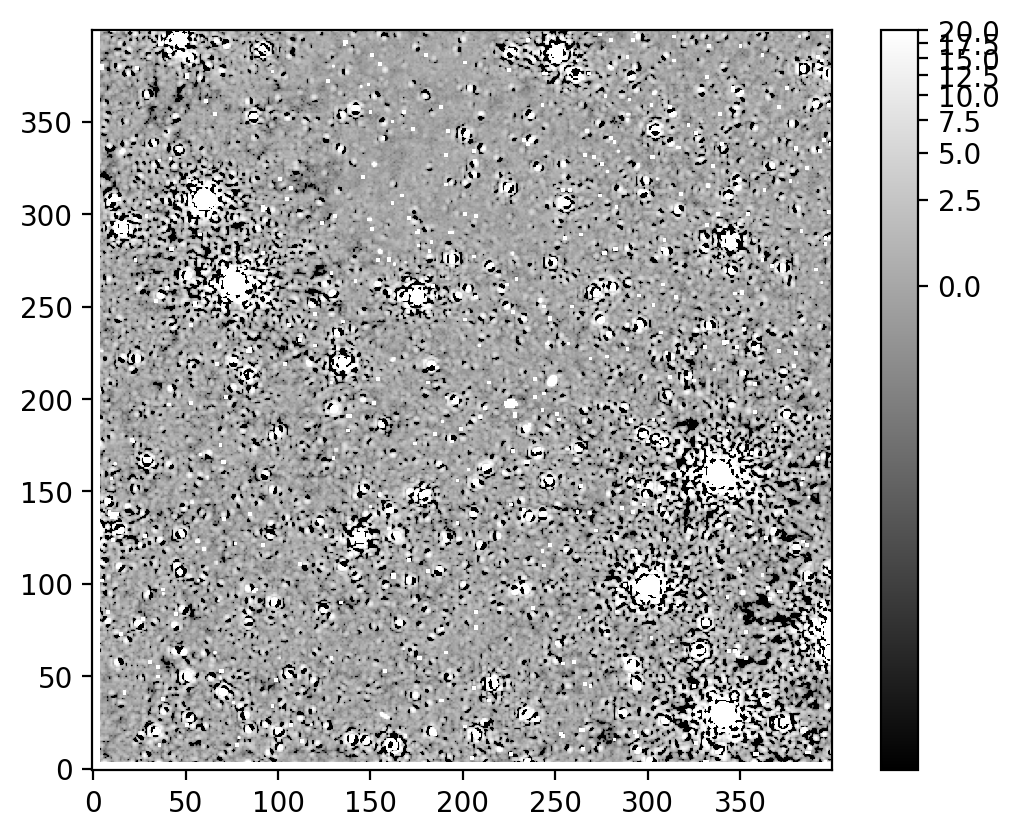

In [23]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=-2, max_cut=20, stretch='log'), cmap='gray')
pl.colorbar();

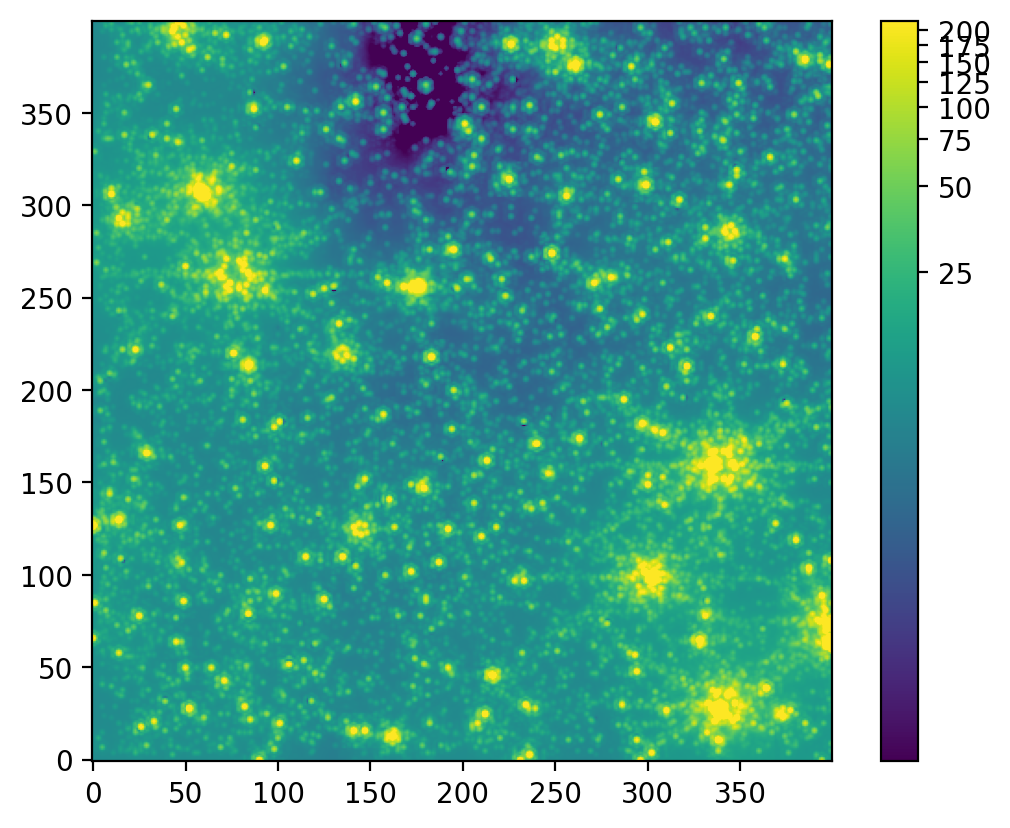

In [24]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

In [25]:
xl,xu,yl,yu = 100,300,200,400
slc = slice(yl,yu), slice(xl,xu)

(0.0, 200.0, 0.0, 200.0)

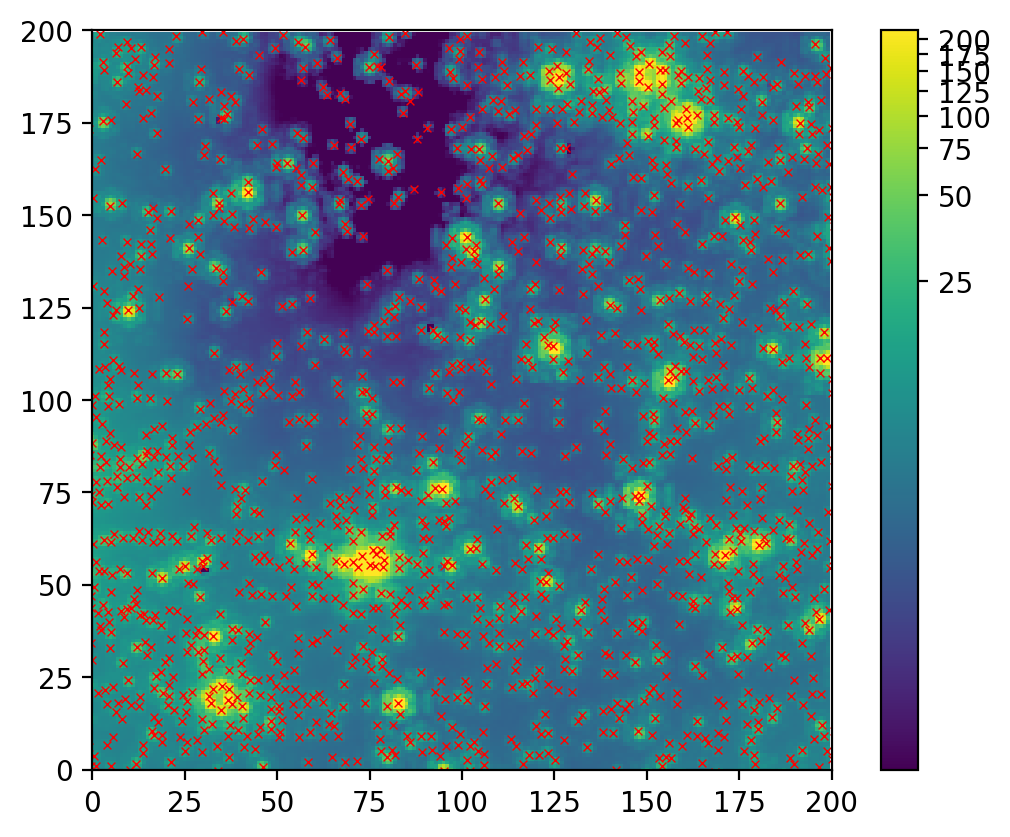

In [26]:
pl.figure(dpi=200)
pl.imshow(model[slc], norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200])

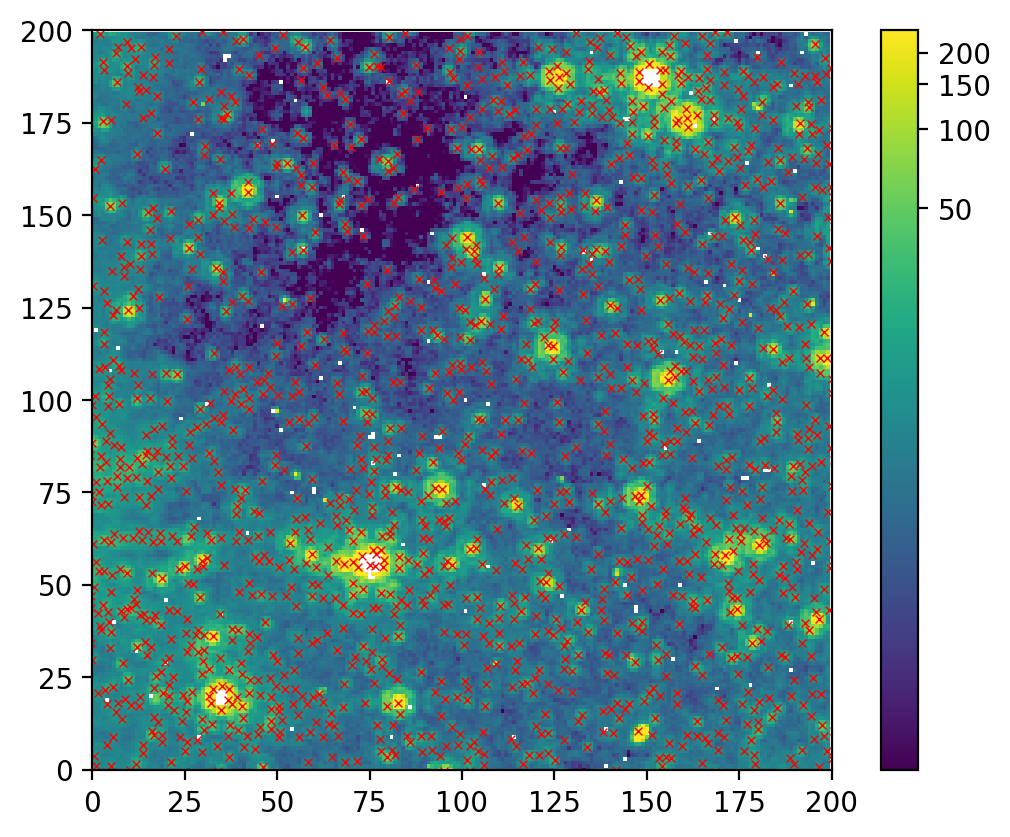

In [27]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

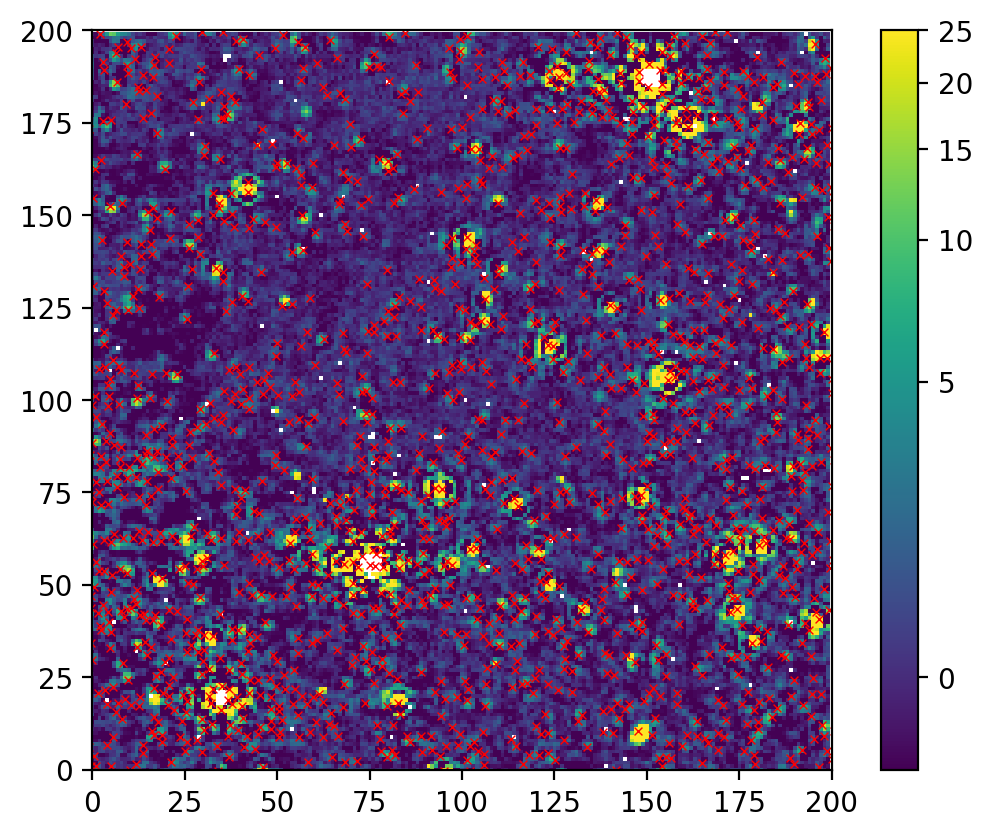

In [28]:
pl.figure(dpi=200)
pl.imshow(residual[slc], norm=simple_norm(residual, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x']-xl, result['y']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

# Residual zoom

In [51]:
import sys
sys.path.append(f'{basepath}/analysis')
import plot_tools
import importlib as imp
imp.reload(plot_tools)
from plot_tools import diagnostic_stamps_by_mag_crowdsource
def diagnostic_stamps_by_mag(*args, **kwargs):
    return diagnostic_stamps_by_mag_crowdsource(*args, filtername=filtername, pixel_area=ww.celestial.proj_plane_pixel_area(), data=data, **kwargs)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


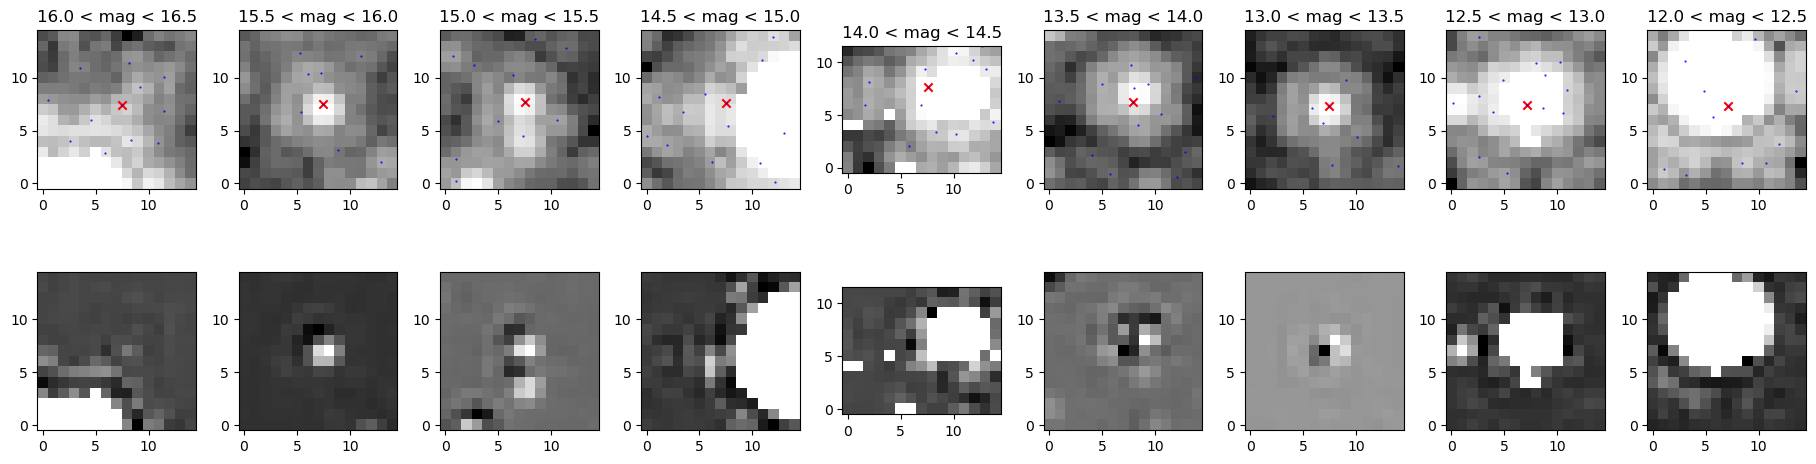

In [52]:
diagnostic_stamps_by_mag(result, residual)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


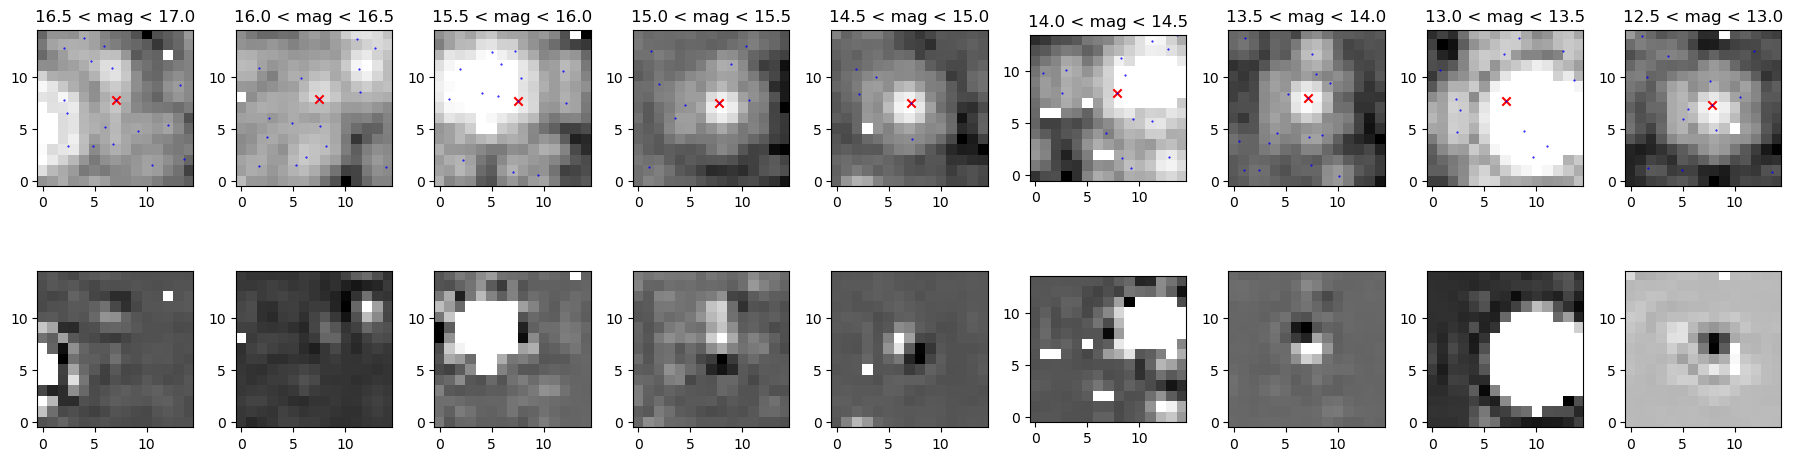

In [53]:
diagnostic_stamps_by_mag(result, residual, ind_offset=1)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


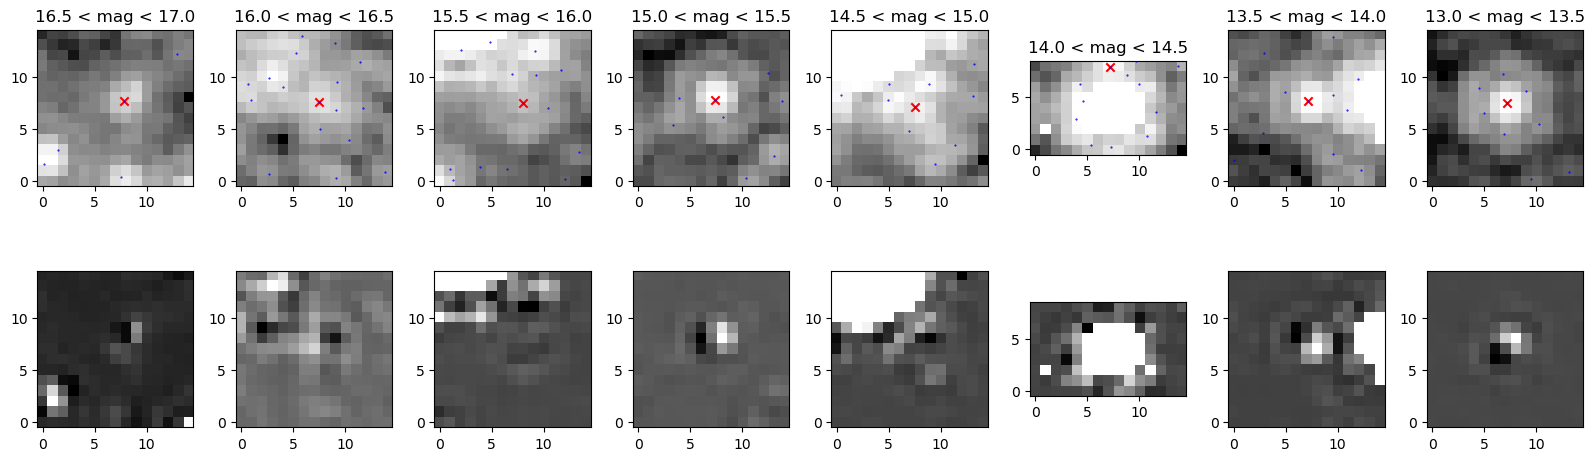

In [54]:
diagnostic_stamps_by_mag(result, residual, ind_offset=2)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


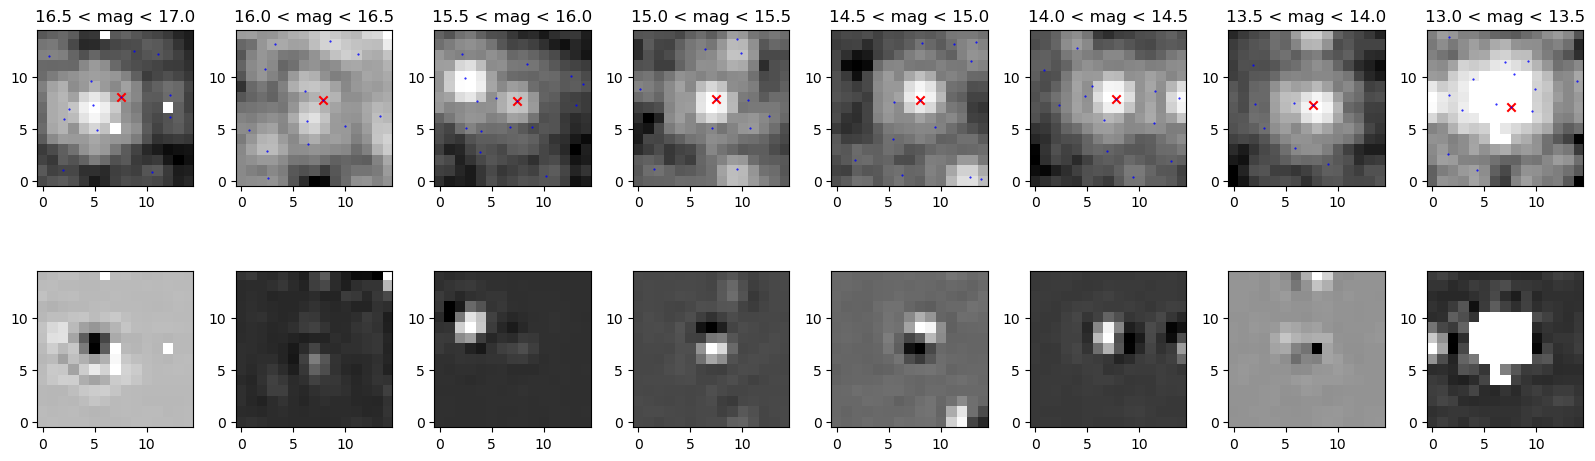

In [55]:
diagnostic_stamps_by_mag(result, residual, ind_offset=3)